# COVID-19のCTデータを可視化する
概要：CT画像とアノテーションマスクデータを使い、病変箇所を可視化する。  
予備知識：
* 医療画像においてはPythonは２次元画像の可視化に向いている。3次元画像は専用ツールを使うことが多い。
* CT画像の場合、ピクセルの値は輝度値ではなくHoundfield Unit(HU)というX線の透過率を使う。HUは水が0(白）、空気が-1000（黒）

## 1. 必要なファイルのパス等を含んだDataFrameを作成する
columns: FilePathImage, FileName, FilePathMask

In [155]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nibabel as nib
from glob import glob
import os
import ctvis
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
base_path = os.path.join('..','..','sample_data','public_covid_data')
glob(base_path+'/*')

['../../sample_data/public_covid_data/rp_im',
 '../../sample_data/public_covid_data/rp_msk']

In [23]:
# im,msk配下のファイルパス、ファイル名を取得し、それぞれdfを作成
df_list = []
for folder in glob(base_path+'/*'):
    files = glob(folder+'/*')
    filenames = [os.path.split(file)[1] for file in files]
    df_list.append(pd.DataFrame({'FilePath':files,'FileName':filenames}))

df_list[0].head()

,FilePath,FileName
0,../../sample_data/public_covid_data/rp_im/4.nii,4.nii
1,../../sample_data/public_covid_data/rp_im/1.nii,1.nii
2,../../sample_data/public_covid_data/rp_im/8.nii,8.nii
3,../../sample_data/public_covid_data/rp_im/9.nii,9.nii
4,../../sample_data/public_covid_data/rp_im/6.nii,6.nii


In [24]:
df_list[1].head()

,FilePath,FileName
0,../../sample_data/public_covid_data/rp_msk/4.nii,4.nii
1,../../sample_data/public_covid_data/rp_msk/1.nii,1.nii
2,../../sample_data/public_covid_data/rp_msk/8.nii,8.nii
3,../../sample_data/public_covid_data/rp_msk/9.nii,9.nii
4,../../sample_data/public_covid_data/rp_msk/6.nii,6.nii


In [22]:
# dfの結合
df = df_list[0].merge(df_list[1], how='inner',on='FileName',suffixes=['Image','Mask']) 
df

,FilePathImage,FileName,FilePathMask
0,../../sample_data/public_covid_data/rp_im/4.nii,4.nii,../../sample_data/public_covid_data/rp_msk/4.nii
1,../../sample_data/public_covid_data/rp_im/1.nii,1.nii,../../sample_data/public_covid_data/rp_msk/1.nii
2,../../sample_data/public_covid_data/rp_im/8.nii,8.nii,../../sample_data/public_covid_data/rp_msk/8.nii
3,../../sample_data/public_covid_data/rp_im/9.nii,9.nii,../../sample_data/public_covid_data/rp_msk/9.nii
4,../../sample_data/public_covid_data/rp_im/6.nii,6.nii,../../sample_data/public_covid_data/rp_msk/6.nii
5,../../sample_data/public_covid_data/rp_im/5.nii,5.nii,../../sample_data/public_covid_data/rp_msk/5.nii
6,../../sample_data/public_covid_data/rp_im/7.nii,7.nii,../../sample_data/public_covid_data/rp_msk/7.nii
7,../../sample_data/public_covid_data/rp_im/3.nii,3.nii,../../sample_data/public_covid_data/rp_msk/3.nii
8,../../sample_data/public_covid_data/rp_im/2.nii,2.nii,../../sample_data/public_covid_data/rp_msk/2.nii


In [32]:
# 上記を関数化する。講座の書き方よりも一般化を意識した。
def get_df(folder='../../sample_data/public_covid_data/rp_im'):
    files = glob(folder+'/*')
    filenames = [os.path.split(file)[1] for file in files]
    return pd.DataFrame({'FilePath':files,'FileName':filenames})

In [31]:
get_df('../../sample_data/public_covid_data/rp_im')

,FilePath,FileName
0,../../sample_data/public_covid_data/rp_im/4.nii,4.nii
1,../../sample_data/public_covid_data/rp_im/1.nii,1.nii
2,../../sample_data/public_covid_data/rp_im/8.nii,8.nii
3,../../sample_data/public_covid_data/rp_im/9.nii,9.nii
4,../../sample_data/public_covid_data/rp_im/6.nii,6.nii
5,../../sample_data/public_covid_data/rp_im/5.nii,5.nii
6,../../sample_data/public_covid_data/rp_im/7.nii,7.nii
7,../../sample_data/public_covid_data/rp_im/3.nii,3.nii
8,../../sample_data/public_covid_data/rp_im/2.nii,2.nii


## 2. NIfTIデータをNumpy Arrayとしてロードする

In [36]:
sample_path = df['FilePathImage'].iloc[0]
nifti = nib.load(sample_path)

In [37]:
data = nifti.get_fdata()

In [38]:
data.shape

(630, 630, 39)

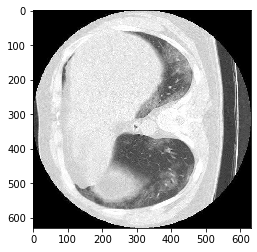

In [40]:
plt.imshow(data[:, :, 10], cmap='gray')

In [42]:
# 見やすいように軸を変える
# 例
a = np.ones((4, 3, 2))
a.shape

(4, 3, 2)

In [43]:
# axis=0(3のとこ)の前にaxis=1(4のとこ)を挿入するイメージ。axis=0は1になる。
np.rollaxis(a, axis=1, start=0).shape

(3, 4, 2)

In [53]:
# dataの軸は現状(w,h,z)なので、(h,w,z)に入れ替える
data_rolled = np.rollaxis(data, axis=1, start=0)

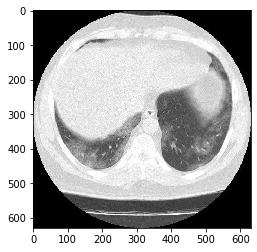

In [54]:
plt.imshow(data_rolled[:, :, 10], cmap='gray')

上下が正しくなった。(h,w,z)

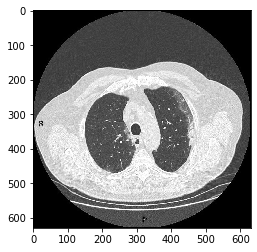

In [58]:
# 上記を関数化したものを呼び出す。
data = ctvis.load_nifti(df['FilePathImage'].iloc[1])
plt.imshow(data[:, :, 10], cmap='gray')

## 3. マスクデータをRGBにする

In [59]:
df

,FilePathImage,FileName,FilePathMask
0,../../sample_data/public_covid_data/rp_im/4.nii,4.nii,../../sample_data/public_covid_data/rp_msk/4.nii
1,../../sample_data/public_covid_data/rp_im/1.nii,1.nii,../../sample_data/public_covid_data/rp_msk/1.nii
2,../../sample_data/public_covid_data/rp_im/8.nii,8.nii,../../sample_data/public_covid_data/rp_msk/8.nii
3,../../sample_data/public_covid_data/rp_im/9.nii,9.nii,../../sample_data/public_covid_data/rp_msk/9.nii
4,../../sample_data/public_covid_data/rp_im/6.nii,6.nii,../../sample_data/public_covid_data/rp_msk/6.nii
5,../../sample_data/public_covid_data/rp_im/5.nii,5.nii,../../sample_data/public_covid_data/rp_msk/5.nii
6,../../sample_data/public_covid_data/rp_im/7.nii,7.nii,../../sample_data/public_covid_data/rp_msk/7.nii
7,../../sample_data/public_covid_data/rp_im/3.nii,3.nii,../../sample_data/public_covid_data/rp_msk/3.nii
8,../../sample_data/public_covid_data/rp_im/2.nii,2.nii,../../sample_data/public_covid_data/rp_msk/2.nii


In [63]:
# CT画像読み込み
p = df['FilePathMask'].iloc[5]
seg_data = ctvis.load_nifti(p)
seg_data.shape

(630, 630, 66)

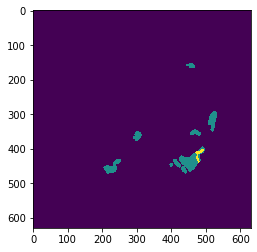

In [64]:
plt.imshow(seg_data[:, :, 30])

In [66]:
np.unique(seg_data[:, :, 30])

array([0., 1., 2.])

断面30のピクセルの値には0,1,2しかない。これはmatplotlibのimshowがつけた色である。  
これら0,1,2,(断面によっては3)をRGBの輝度値に対応させて表示する。  
基本的な考え方は、マスクデータの配列(seg_data)の0,1,2が格納されている箇所と輝度値を  
対応させた配列を作成する。

In [130]:
# まずRGB対応用の要素がゼロの配列を作成する。
# 次元は元々の画像データの次元（３次元）＋輝度値の計４次元の配列を作成する。
# 各断面の画像に輝度値の属性（次元）を持たせるイメージ
shp = seg_data.shape
# 中身は(630,630,66,3)
seg_color = np.zeros((shp[0], shp[1], shp[2], 3))
seg_color.shape

(630, 630, 66, 3)

これはshapeが(630, 66, 3)の3次元配列が660個ある4次元配列である。  
(630, 66, 3)は(66, 3)の2次元配列が630個ある3次元配列である。

In [143]:
# numpy arrayの条件に合うものを置き換えるのはnp.whereでできる
filter_array = np.where(seg_data==1, True, False)

# またはwhereの箇所は下記のようにもかける。こっちの方がすっきりしている。
# np.equal(seg_data, 1)

In [83]:
filter_array.shape

(630, 630, 66)

In [126]:
# 要素が1の部分がTrue,そうでないものはFalseに置き換わっている。
filter_array

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [132]:
# filter_array=Trueのものでフィルタリング。
# 復習：.whereは論理式だけ指定すると、Trueの要素の各次元のインデックスが返ってくる。
np.where(filter_array)

(array([152, 152, 153, ..., 485, 485, 485]),
 array([454, 455, 452, ..., 404, 405, 406]),
 array([30, 30, 30, ..., 19, 19, 19]))

In [109]:
# seg_data[152][454][30]に1があることがわかる。
filter_array[152][454]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [129]:
# filter_arrayでフィルタリングするのはseg_colorの3つ目の次元まで指定することに相当する。
seg_color[filter_array]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [127]:
seg_color[152][454][30]

array([0., 0., 0.])

★分かりづらいポイント  
filter_arrayのshapeは(630, 630, 66)であり、これをインデックスとして  
4次元配列のseg_colorに入れることで、4次元のうち3次元までのインデックスを指定していることになる。  
つまりseg_colorのどの3次元配列の中のどの2次元配列のどの行かまでを指定している。  
その結果、輝度値の次元（2次元配列のある行の値（リスト））が残る。  
seg_color[filter_array]が2次元配列なのは、Trueの箇所ごとに輝度値の行があるため。

In [131]:
# 要素が1の箇所に[255, 0, 0]（Redに相当）を入れる。
# 復習：行に要素数が同じリストを代入すると、行まるごと入れ替わる
seg_color[filter_array] = [255, 0, 0]
seg_color[filter_array]

array([[255.,   0.,   0.],
       [255.,   0.,   0.],
       [255.,   0.,   0.],
       ...,
       [255.,   0.,   0.],
       [255.,   0.,   0.],
       [255.,   0.,   0.]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


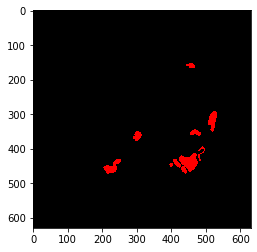

In [140]:
# 断面を見てみる。
plt.imshow(seg_color[:, :, 30])

In [151]:
shp = seg_data.shape
seg_color = np.zeros((shp[0], shp[1], shp[2], 3),dtype=np.float32)
# 他のラベル(2, 3)についても見てみる。
# カラーラベル定義（変数名の意味は講座を参照）
ggo_color = [255, 0, 0]
consolidation_color = [0, 255, 0]
effusion_color = [0, 0, 255]

# 色付け。seg_dataの各要素とラベル番号が等しい箇所へカラーラベルのリストを代入
seg_color[np.equal(seg_data, 1)] = ggo_color
seg_color[np.equal(seg_data, 2)] = consolidation_color
seg_color[np.equal(seg_data, 3)] = effusion_color

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


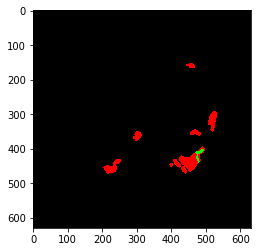

In [152]:
plt.imshow(seg_color[:, :, 30])

In [158]:
# 上記を関数化して実行してみる。
mask_color = ctvis.label_color(seg_data)
mask_color.shape

(630, 630, 66, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


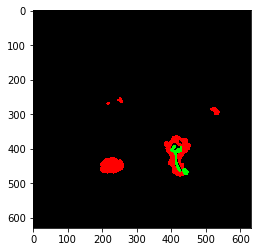

In [160]:
plt.imshow(mask_color[:, :, 20])

## 4. HUをグレースケールに変換する
元のCT画像の各ピクセルの情報は輝度値ではなくHUなので、0-255の値ではない。このままではアノテーションマスクと重ねることができないので、0-255のグレースケールに変換する。

In [257]:
index = 5
volume = ctvis.load_nifti(df.iloc[index]['FilePathImage'])
mask = ctvis.load_nifti(df.iloc[index]['FilePathMask'])
mask_color = ctvis.label_color(mask)

In [202]:
volume.shape

(630, 630, 66)

In [203]:
mask.shape

(630, 630, 66)

In [204]:
mask_color.shape

(630, 630, 66, 3)

In [205]:
volume

memmap([[[-1047.62854004, -1041.65917969, -1035.73071289, ...,
          -1017.82244873, -1023.79187012, -1041.65917969],
         [-1035.73071289, -1035.73071289, -1029.76123047, ...,
          -1035.73071289, -1035.73071289, -1035.73071289],
         [-1029.76123047, -1035.73071289, -1029.76123047, ...,
          -1053.59790039, -1041.65917969, -1035.73071289],
         ...,
         [-1035.73071289, -1035.73071289, -1047.62854004, ...,
          -1035.73071289, -1035.73071289, -1035.73071289],
         [-1035.73071289, -1041.65917969, -1035.73071289, ...,
          -1035.73071289, -1029.76123047, -1035.73071289],
         [-1035.73071289, -1047.62854004, -1023.79187012, ...,
          -1035.73071289, -1029.76123047, -1035.73071289]],

        [[-1047.62854004, -1047.62854004, -1041.65917969, ...,
          -1029.76123047, -1023.79187012, -1041.65917969],
         [-1035.73071289, -1041.65917969, -1041.65917969, ...,
          -1041.65917969, -1035.73071289, -1035.73071289],
        

In [174]:
print(volume.min())
print(volume.max())

-1339.6790771484375
156.22637939453125


In [176]:
print(mask_color.min())
print(mask_color.max())

0.0
255.0


In [258]:
# 値を0-255に変換する
maxhu = np.max(volume)
minhu = np.min(volume)
# broadcastingが働くため、volume-minhuはvolumeの各要素に実行される。
# maxhuとminhuが等しい場合を考慮し、max関数を分母に適用しておく。
# max()関数は引数のうち大きい方を返す。
volume_rerange = (volume - minhu) / max((maxhu - minhu), 1e-3)
volume_rerange = volume_rerange * 255

In [207]:
volume_rerange.min()

0.0

In [208]:
volume_rerange.max()

255.0

In [209]:
volume_rerange.shape

(630, 630, 66)

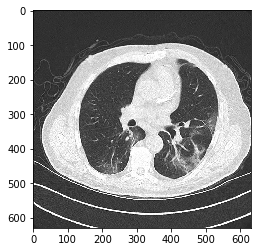

In [241]:
plt.imshow(volume_rerange[:, :, 30],cmap='gray')

In [242]:
volume_rerange.shape

(630, 630, 66)

In [243]:
# マスクと重ねるために、volume_rerangeのshapeを合わせる
volume_rerange = np.stack([volume_rerange, volume_rerange, volume_rerange], axis=-1)
volume_rerange.shape

(630, 630, 66, 3)

volume_rerangeを3つstackしているため、3列の要素は全て同じ。  
RGB全て輝度値が同じなので、灰色の濃淡になり、結果としてグレースケールとなる。  
66断面に3つの同じ要素（輝度値）を持たせるイメージ。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


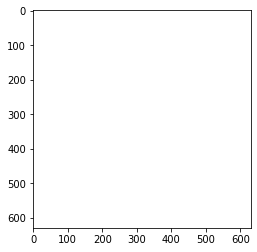

In [244]:
plt.imshow(volume_rerange[:, :, 20])

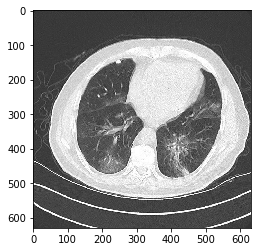

In [234]:
# floatなので、imshowで出力するにはintに変換する必要あり。
plt.imshow(volume_rerange.astype(np.uint8)[:, :, 20])

In [259]:
# 上記を関数化して実行する。
volume_gray = ctvis.hu_to_gray(volume)

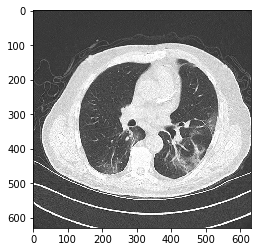

In [260]:
plt.imshow(volume_gray[:, :, 30])

In [235]:
volume_gray.max()

255

In [236]:
volume_gray.min()

0

In [237]:
volume_gray.shape

(630, 630, 66, 3)

## 4. CTとアノテーションマスクをOverlay（重ねる）する

In [245]:
# まず、RGB値の違いによる色の変化を見てみる。
a = np.array([[[100, 100, 100]]])
a.shape

(1, 1, 3)

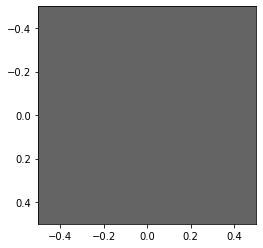

In [246]:
plt.imshow(a)

全て同じ輝度値なので、グレー

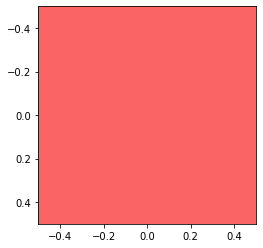

In [251]:
plt.imshow(np.array([[[250, 100, 100]]]))

値を大きくする、または他の色の輝度値を下げると、最も大きい値の色味が強くなる。（上は赤）

In [252]:
original = np.array([[[100, 100, 100]]])
color = np.array([[[255, 0, 0]]])

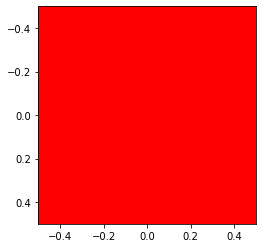

In [253]:
plt.imshow(color)

In [254]:
# 重ね合わせた後の輝度値を設定する。
overlayed = (0.7*original + 0.3*color).astype(np.uint8)

In [255]:
overlayed

array([[[146,  70,  70]]], dtype=uint8)

重ね合わせる際は合計の割合が1(100%)となるように足す。  
こうすることで、仮にoriginal,colorの値がどちらも255だとしても輝度値の上限(255)を超えない範囲で  
重ね合わせ後の輝度値を設定できる。

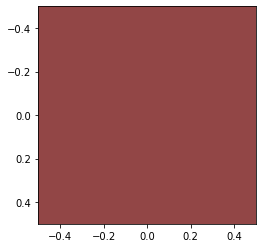

In [256]:
plt.imshow(overlayed)

In [261]:
# グレースケールのCT画像に上記の考え方で輝度値を設定
overlayed = (0.7*volume_gray + 0.3*mask_color).astype(np.uint8)

In [262]:
overlayed.shape

(630, 630, 66, 3)

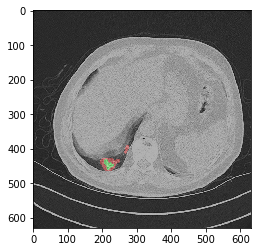

In [264]:
plt.imshow(overlayed[:, :, 10])

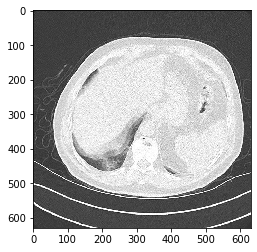

In [265]:
plt.imshow(volume_gray[:, :, 10])

全ピクセルの輝度値に0.7をかけたので、明るさが変わってしまっている。  
マスクがあるところだけに適用する必要あり。

In [266]:
# .whereでmask_color=255、つまり0より大きいピクセルに対して処理をする。
# Falseの場合はvolume_grayそのままの値を使う。volume_grayはmask_colorと同じインデックスに沿って処理される。
overlayed = np.where(mask_color > 0, (0.7*volume_gray + 0.3*mask_color).astype(np.uint8), volume_gray)

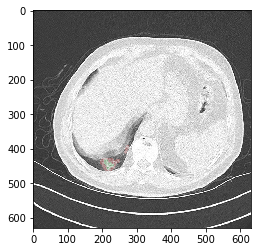

In [267]:
plt.imshow(overlayed[:, :, 10])

上記ではwhereの結果Trueの要素しか重ね合わせされないので、volume_grayのRGB3つの輝度値のうち1つしか重ね合わせ  
の処理がされない（mask_colorが[255, 0, 0]等なので１つだけ）。  
つまり、赤を強調したい要素でも青、緑の輝度値が0.7がけされずに残るので色味が薄くなる。  
この対策として、元々のマスクデータ(0,1,2,3)で0よりも大きいマスクをTrueにしてフィルタリングすればよい。

In [308]:
mask.shape

(630, 630, 66)

In [297]:
# np.where(mask > 0 , True, False)
# mask > 0 すなわち赤、青、緑に相当する要素がTrueになる。
mask_filter = np.greater(mask, 0)

In [298]:
np.where(mask_filter)

(array([152, 152, 153, ..., 485, 485, 485]),
 array([454, 455, 452, ..., 404, 405, 406]),
 array([30, 30, 30, ..., 19, 19, 19]))

In [299]:
# RGB用の次元を用意
# mask_filterの全要素（True,False）が１列に並んでいて、それが3列あるイメージ
mask_filter = np.stack([mask_filter, mask_filter, mask_filter], axis=-1)

In [300]:
mask_filter.shape

(630, 630, 66, 3)

In [303]:
# 赤、青、緑についてTrueになり、重ね合わせが実行される。
overlayed = np.where(mask_filter, (0.7*volume_gray + 0.3*mask_color).astype(np.uint8), volume_gray)

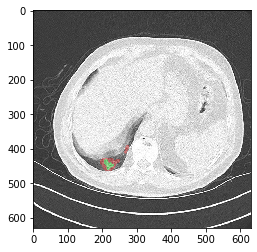

In [304]:
plt.imshow(overlayed[:, :, 10])

In [309]:
# 上記を関数化してみる。
overlayed = ctvis.overlay(volume_gray, mask, mask_color, alpha=0.5)

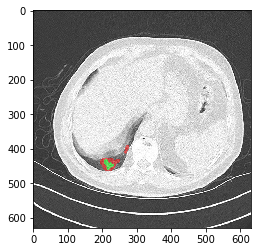

In [310]:
plt.imshow(overlayed[:, :, 10])

## 5. 各スライスを並べて表示する

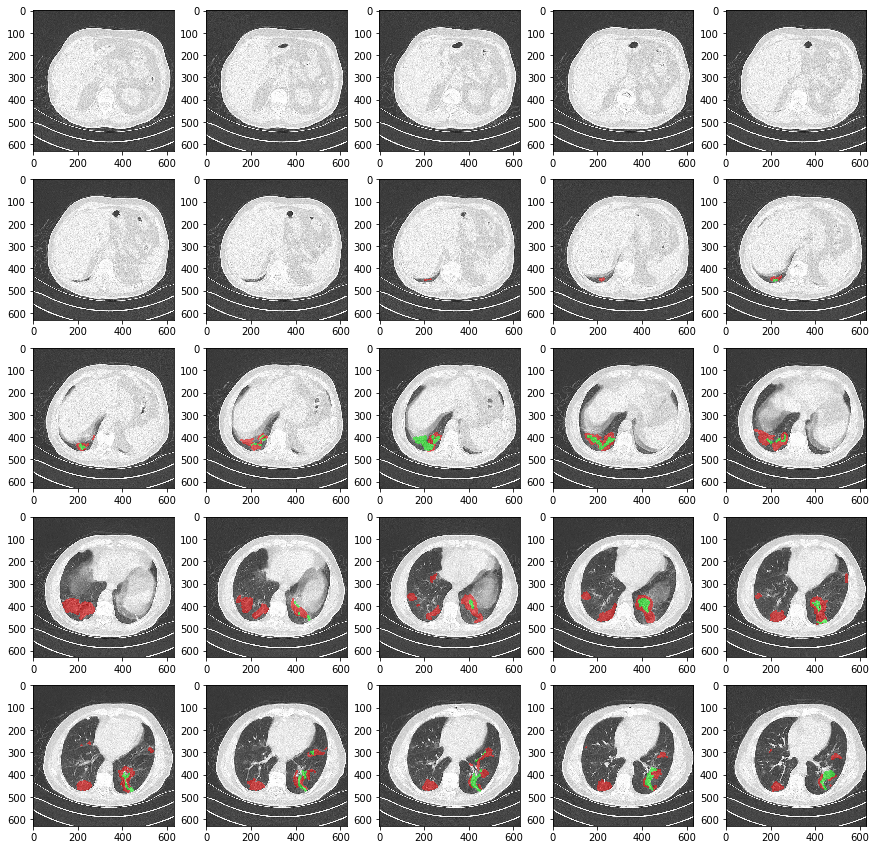

In [316]:
# 下記にそれぞれの断面のデータを表示するイメージ
rows = 5
cols = 5
figsize = (15, 15)
fig, ax = plt.subplots(rows, cols, figsize=figsize)

# 行列のインデックスはリストのiをカラム数で割った商と余りになる。
for i in range(25):
    ax[i//cols, i%cols].imshow(overlayed[:, :, i])